# Install dependencies and import libraries

In [1]:
!pip install -Uq fastbook fastai duckduckgo_search

I quite like how you can see which libraries are currently installed. Here is a list of all libraries currently available that begin with 'f'.

In [2]:
#!pip list | grep "^fast"

In [3]:
from fastbook import *
from duckduckgo_search import DDGS, AsyncDDGS
from fastcore.all import *
from itertools import islice
from IPython.display import HTML
from shutil import move
from fastai.vision.widgets import *

# Function definitions

In [4]:
# Search for images and return a list of URLs.
def search_images(term, max_images = 250):
    print(f"Searching for {max_images} '{term}' images...")
    keywords = term
    ddgs_images = ddgs.images(keywords, max_results=max_images)
    #limited_images = list(islice(ddgs_images, max_images))
    return L(ddgs_images).itemgot('image')

In [5]:
# Download images for the specifed search term.
#
# 1. If the search term contains spaces then hyphenate for the folder name.
# 2. Skip if images already exist.
#
def download_image_urls(search_term, max_images, resize=True):
    search = search_images(search_term, max_images)
    dest_search_term = search_term.replace(' ', '-')
    dest = Path(path)/dest_search_term
    if dest.exists() and any(dest.iterdir()):
        num_images_before = len([1 for _ in dest.iterdir()])
        print(f"{num_images_before} images already downloaded in {dest}, skipping download.")
    else:
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search)
        num_images_downloaded = len([1 for _ in dest.iterdir()])
        if resize:
            print(f"Resizing images...")
            resize_images(dest, max_size=400, dest=dest)
        print(f"{num_images_downloaded} images downloaded and resized in {dest}.")

In [6]:
# Verify downloaded files.
#
# 1. Move failed images to '/deleted' folder for inspection.
# 2. Output information on number of files checked, and failed images.
#
def verify_downloaded_images():
    image_files = get_image_files(path)
    num_images_checked = len(image_files)
    print(f"Number of images to be checked: {num_images_checked}")

    failed = verify_images(image_files)

    # Create a 'deleted' folder if it doesn't exist
    deleted_folder = Path(path).parents[1] / 'deleted'
    deleted_folder.mkdir(exist_ok=True)

    for failed_image in failed:
        new_location = deleted_folder / failed_image.name
        print(f"Moving failed image: {failed_image} to {new_location}")
        move(failed_image, new_location)
        
    print(f"Number of failed images moved to 'deleted' folder: {len(failed)}")
    return failed

In [7]:
# Display the images used in the training set, and validation set.
def displayRandomSplitter(v_pct=0.2, sd=42):
    # Get a list of files (or items) in your dataset
    items = get_image_files(path)
    
    # Initialize the RandomSplitter
    splitter = RandomSplitter(valid_pct=v_pct, seed=sd)
    
    # Apply the splitter to your dataset
    train_indices, valid_indices = splitter(items)
    
    # Function to create a DataFrame from file indices
    def create_dataframe(file_indices):
        data = [(items[i].name, items[i].parent.name) for i in file_indices]
        df = pd.DataFrame(data, columns=['Filename', 'Parent Folder'])
        #sorted = df.sort_values(by='Parent Folder')
        return df
    
    # Create DataFrames for training and validation sets
    train_files = create_dataframe(train_indices)
    valid_files = create_dataframe(valid_indices)
    
    # Convert DataFrames to HTML
    train_html = train_files.to_html(index=False)
    valid_html = valid_files.to_html(index=False)
    
    # Display the HTML tables side by side
    html_content = f"""
    <div style="height:150px;">
        <div style="float: left; padding-right: 20px;">
            <h3 style="text-align:center">Training Set Files</h3>
            {train_html}
        </div>
        <div style="float: left;padding-left:50px;">
            <h3 style="text-align:center">Validation Set Files</h3>
            {valid_html}
        </div>
    </div>        
    """
    display(HTML(html_content))

In [8]:
ddgs = DDGS()

C:\Users\dvgwy\AppData\Local\Temp\ipykernel_13624\3229993807.py:1: UserWarning: DDGS running in an async loop. This may cause errors. Use AsyncDDGS instead.
  ddgs = DDGS()


# Download images

Let's download a sample bear image.

In [9]:
ims = search_images('grizzly', 1); ims[0]

Searching for 1 'grizzly' images...


'http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly+Bear+Wildlife.jpg'

In [10]:
dest = 'images/sample/grizzly.jpg'
download_url(ims[0], dest)

Path('images/sample/grizzly.jpg')

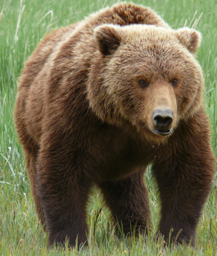

In [11]:
im = Image.open(dest)
im.to_thumb(256,256)

Let's now download some images for three bear types.

In [12]:
path = Path('images/bears')
bear_types = 'grizzly','black','teddy'

In [13]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear')
        download_images(dest, urls=results)
else:
    print(f"Bear images folder already exists resized in {dest}.")        

Bear images folder already exists resized in images/sample/grizzly.jpg.


In [14]:
verify_downloaded_images()

Number of images to be checked: 533
Number of failed images moved to 'deleted' folder: 0


(#0) []

# Train the model

Before attempting to clean the data let's run our model first. This might seem a little unintuitive but let's try it and see what happens.

We'll create the `DataBlock`.

In [15]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = bears.dataloaders(path)

Let's see how the `RandomSplitter` selects the data.

In [16]:
displayRandomSplitter(0.2, 42)

Filename,Parent Folder
5a819865-61f2-4fdf-9a0d-be1d52b4c936.jpg,grizzly
999da24d-05b1-4403-a233-25c395c37003.jpg,grizzly
7d62e56f-fdcd-46d5-b1ff-066677c36cfd.jpg,teddy
457a0067-f842-4645-9a45-9b5515f6b42c.jpg,black
32bcbbde-0975-446a-885c-647fcf35b9e6.jpg,grizzly
58c333f2-6199-4612-a246-28394caf0813.jpg,black
163383f1-79c7-4d19-9c1f-081527167595.jpg,black
65bd001d-c91b-4b62-afd6-c349e843416f.jpg,grizzly
f4eb7a3b-c66e-4eb4-b2e7-7f3865cddd0d.jpg,teddy
1752cb69-9f6a-4a2b-a2b4-cefe73d14412.jpg,teddy


Let's view a sample of our validation data, and training data.

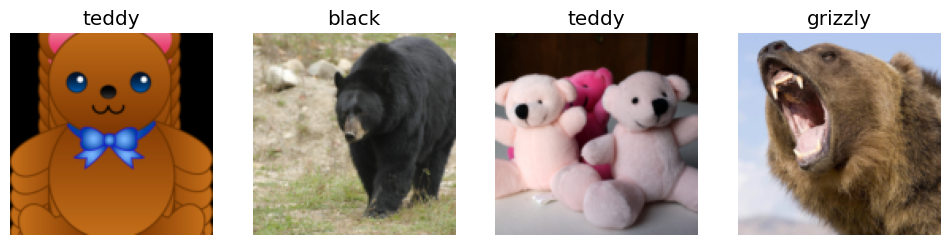

In [17]:
dls.valid.show_batch(max_n=4, nrows=1)

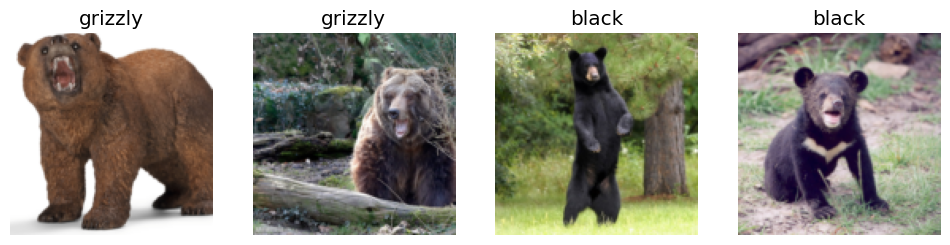

In [18]:
dls.train.show_batch(max_n=4, nrows=1)

Let's use `RandomResizeCrop` instead of `Resize` as this will select different parts of each image during each epoch, leading to better training of our model. We can also use data augmentation too that will apply rotation, flipping, perspective warping, brightness and contrast transforms to each image.

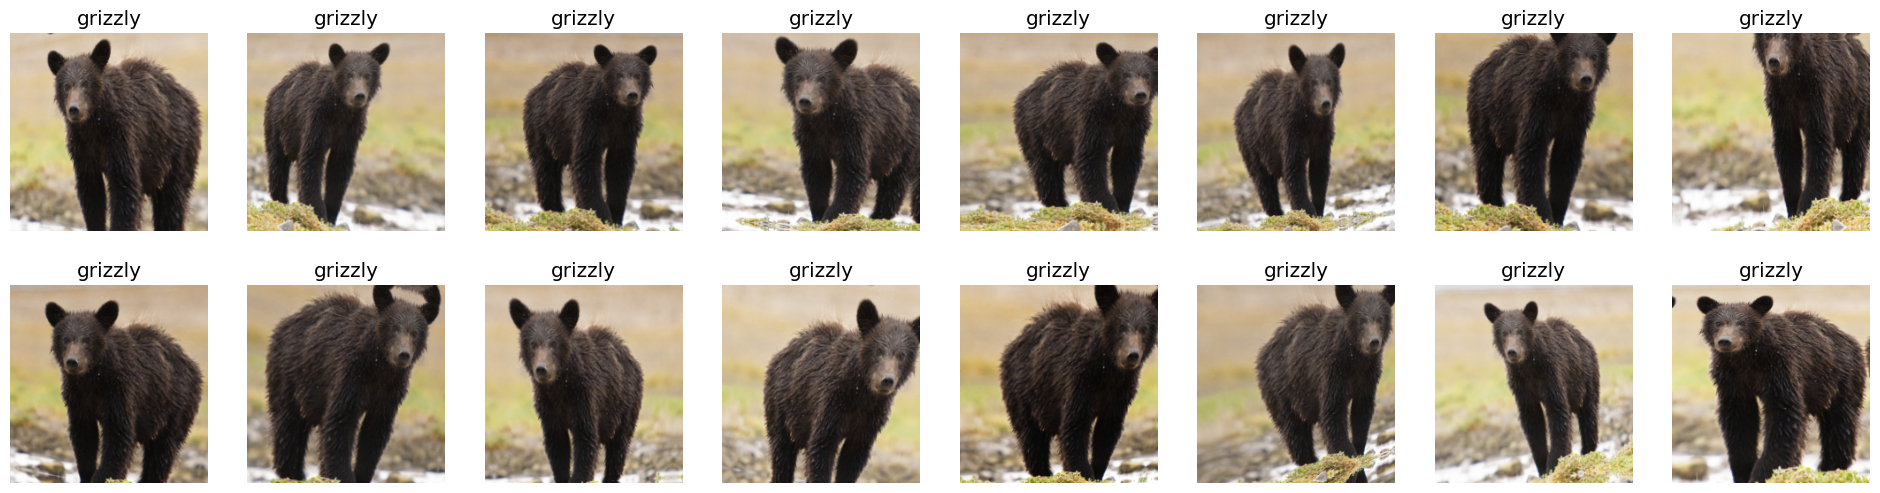

In [19]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=16, nrows=2, unique=True)

Now let's train the model!

In [20]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.107477,0.234485,0.084906,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.207518,0.116815,0.056604,00:40
1,0.172571,0.058164,0.028302,00:40
2,0.131942,0.036638,0.009434,00:39
3,0.123047,0.035233,0.009434,00:40


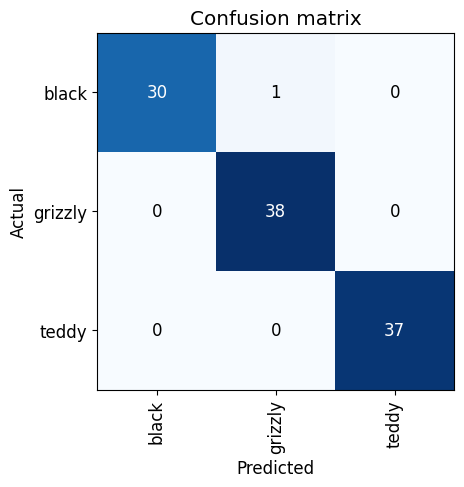

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

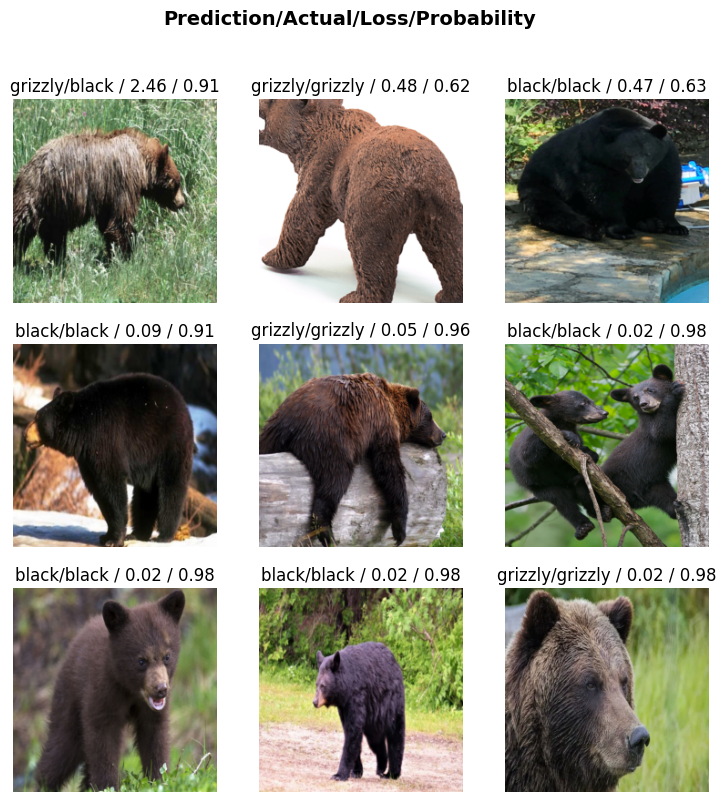

In [24]:
plt.rcParams['font.size'] = 10
interp.plot_top_losses(9, nrows=3)

In [23]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [70]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [71]:
learn.export('model.pkl')

# Notes

Notes from Lesson 2 of the course.

## Data augmentation

Important to understand that `RandomResizedCrop` will only generate **one** cropped (and resized) image for each image in the training set, for each epoch. This does not include the original unaltered image at all apparently.

My understanding is that if you have `RandomResizedCrop` enabled, for each epoch it will take each image in the training set and randomly crop and resize it. And at no time is the original unaltered image used in any epochs.

I found that quite interesting as I initially thought that `RandomResizedCrop` randomly generated a bunch of images based on the original image for each epoch, so this clarification is really useful.

At some point in the future I wonder what effect on a model, using the original unaltered image for the first epoch would have.

## Using PKL files on Hugging Face

I think there are some general [security concerns](https://forums.fast.ai/t/lesson-2-official-topic/96033/710) when using `*.pkl` files. And Hugging Face will usually display a warning when you try to use them.

[Safetensors](https://huggingface.co/docs/safetensors/index) seem to be the preferred alternative to `*.pkl` files thses days.

It will be interesting to see if fastai adds support for the Safetensors format in the future.

## Exporting code from a notebook

Just over halfway through Lesson 2 in the video lecture Jeremy discusses how to [author code](https://youtu.be/F4tvM4Vb3A0?t=2905) in a notebook and export it for use in other applications, such as a Gradio application hosted on Hugging Face.


## Using a PKL model in JavaScript application

Jeremy discusses how to use a trained model exported as a `*.pkl` file in a JavaScript application by hosting the model on a server (e.g. Hugging Face) and using the api to make predictions on the model and return results. This is OK for testing but for production you would probably want to host your model on a dedicated server platform such as Vercel or one of the many others available.


## Issues

- Had a problem when using the `DDGS()` function. It still worked though.
- The `ImageClassifierCleaner` widget would not work properly for me locally (worked on Google Colab). I think this might be because I'm running notebook v7 locally and on Google Colab it's v6.5.5 so the classifier cleaner may have conflicts notebook v7?
- Had some weird random issues with local notebooks. Kept halting execution and jumping back to the first cell in the notebook which was really annoying. Turns out this was caused by the RTC (collaboration) Jupyter extension.
- Am interested in being able to run and edit a notebook on Google Colab that is stored on GitHub and updates the repo when the notebook has been updated.

# Homework
My own classifier model.

Needed to do a bit of manual data cleaning. There were quite a few cartoon type images that I removed, as well as anything that didn't look like it belonged in the data set.

In Lesson 2 Jeremy recommends training the model before doing any data cleaning, but in this notebook I cleaned the data manually before doing any training. 

# Conclusion

Add here.